# Single analysis notebook

This notebook aims to create enviroment to simply test strategies developed in Stocks & Loss system for python

In [5]:
# imports 
from scraper import stock_daily
from analyzer import Analyzer
from IPython.display import display
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import indicators as ind

## Settings
* Select stock ticker
* Define buy and sell strategy (buystrat and sellstrat)
* Define if you want to run stop loss and what value
* Same with profit taker

In [7]:
ticker = "NET"
# stop loss
sl = True
slval = 0.06
# profit taker
pt = False
ptval = 0.11
# repeteated buys
rb = False

## Running calculation

In [9]:
# scraping / loading data
stock = stock_daily(ticker, save=False)
# creating analyzer instance
trades = Analyzer(ticker=ticker, data=stock.data)

## Building the trade strategy

In [11]:
# ================> Buy strategy: SVF
# STRATEGY DEFINITIONS
# calculating VFI
vfi = ind.vfi(stock.data, period=30, coef=0.2, vcoef=1.5)
fs = ind.stoch(stock.data, period=5, sk=2, sd=3)
# calculating VFI histogram trend
window = 3
vfi_hist = vfi["histogram"].rolling(window=window).apply(lambda x: np.polyfit(np.arange(window), x, 1)[0], raw=True).values
vfi_hist = vfi_hist > 0
# VFI trend
vfi_trend = vfi["vfi"] > vfi["vfi_smooth"]
vfi_conf = np.logical_or(vfi_hist, vfi_trend)
# calculating fast stochastic trend
window = 4
fs_conf = fs["k"].rolling(window=window).apply(lambda x: np.polyfit(np.arange(window), x, 1)[0], raw=True).values
fs_conf = fs_conf > 0
# buy signals in uptrend
bss = trades.mb_stoch(period=21, sk=2, sd=5, treshold=0, tcross="d")
# finalize buy signals
bsf = np.logical_and(np.logical_and(fs_conf, vfi_conf), bss)
# throw exception if buy signal is empty
if bsf.sum() == 0:
    raise RuntimeError("No buy signals were generated by this strategy.")

# WRITE SELL METHOD WHICH CREATES 
# ================> Sell strategy: SMA cross
# for N buy signals, create N sell vectors where Nth column will be the sell signal for Nth buy signal, 
# some sell methods that are independent will have copied columns

ss = np.roll(bsf,10)
ssf = np.repeat([ss,], repeats=np.sum(bsf), axis=0)

# sort signals
ss = trades.signalSorter(bsf,ssf,rb) 

In [13]:
# building final strategy
trades.strategy(ss, stopLoss=sl, stopLossValue=slval, profitTaker=pt, profitTakerValue=ptval)
# evaluating strategy
summary = trades.profit(capitalForEachTrade=500, comission=2)
profitByHolding = 100*((trades.data["Close"].iloc[-1]-trades.data["Close"].iloc[0])/trades.data["Close"].iloc[0])

# dates for plot
# taking stock.data and changing index to column and Date to index
dates = stock.data.copy()
dates["index1"] = dates.index
dates = dates.set_index("Date")

# find index of buy dates of good trades
bdg = summary["Buy date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdg = summary["Sell date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdg = dates["index1"].reindex(bdg).to_numpy()
sdg = dates["index1"].reindex(sdg).to_numpy()
   
# find index of buy dates of bad trades
bdb = summary["Buy date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdb = summary["Sell date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdb = dates["index1"].reindex(bdb).to_numpy()
sdb = dates["index1"].reindex(sdb).to_numpy()

In [14]:
summary.shape[0]

9

# Results

In [17]:
print('Absolute profit last year:                ',np.round(summary["Profit[$]"].sum(),2),'$')
print('Relative profit last year:                ',np.round(summary["Profit[%]"].sum(),2),'%')
print('Relative profit by holding last year:     ',np.round(profitByHolding,2),'%')

Absolute profit last year:                 84.08 $
Relative profit last year:                 16.82 %
Relative profit by holding last year:      298.54 %


In [20]:
display(summary)

,Buy date,Buy price,Buy value,Position,Sell date,Sell price,Sell value,Comission,Good trade?,Profit[$],Profit[%]
0,2020-12-18,83.809998,500,5.965875,2020-12-28,78.781398,470.000000,2,0.0,-32.000000,-6.400000
1,2021-01-07,79.019997,500,6.327512,2021-01-22,83.470001,528.157459,2,1.0,26.157459,5.231492
2,2021-02-01,80.480003,500,6.212723,2021-02-16,82.070000,509.878207,2,1.0,7.878207,1.575641
3,2021-03-01,76.900002,500,6.501950,2021-03-03,72.286001,470.000000,2,0.0,-32.000000,-6.400000
4,2021-03-31,70.260002,500,7.116424,2021-04-15,78.089996,555.721563,2,1.0,53.721563,10.744313
5,2021-04-22,75.430000,500,6.628662,2021-05-06,70.904200,470.000000,2,0.0,-32.000000,-6.400000
6,2021-05-12,69.690002,500,7.174630,2021-05-26,79.879997,573.109445,2,1.0,71.109445,14.221889
7,2021-07-20,107.680000,500,4.643388,2021-08-03,119.570000,555.209878,2,1.0,53.209878,10.641976
8,2021-08-10,125.470001,500,3.985016,2021-08-11,117.941801,470.000000,2,0.0,-32.000000,-6.400000


## Visualizations

Successful trades are showcased as a light green fill, similarly, failed trades as a red fill

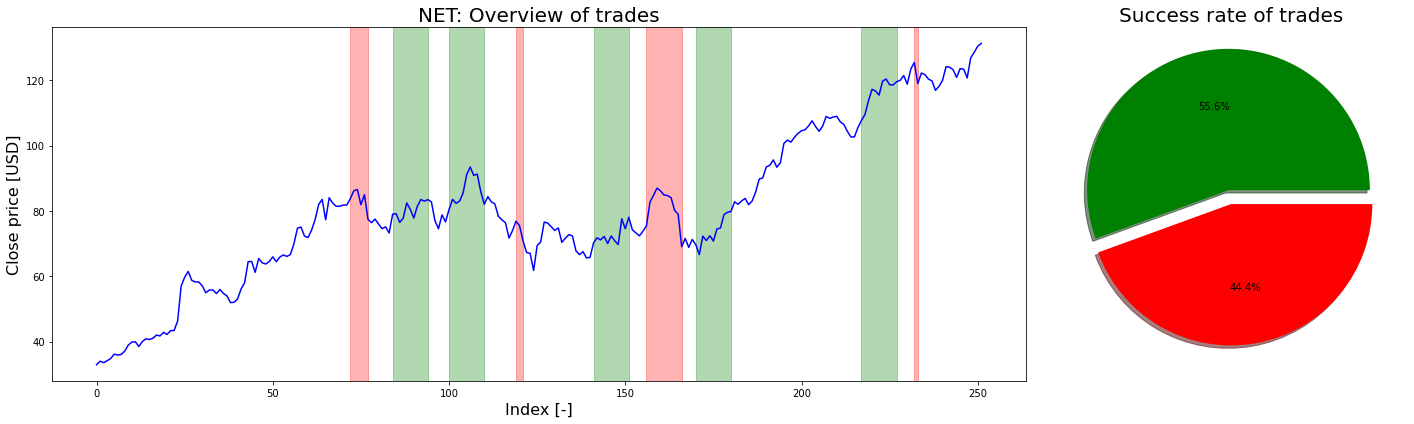

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6), gridspec_kw={'width_ratios': [2.5, 1]})

# plot closed prices and highlighted trades
ax[0].plot(stock.data["Close"], color="b")
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlabel("Index [-]", fontsize=16)

gtrades = summary["Good trade?"].sum()
btrades = summary["Good trade?"].size
# plot piechart with percentage of succesful trades (profit / loss)
ax[1].pie([gtrades, btrades-gtrades], colors=["g","r"], shadow=True, explode=(0.1, 0), autopct="%1.1f%%")
ax[1].set_title("Success rate of trades", fontsize=20)

fig.tight_layout()

Text(0.5, 0, 'Index [-]')

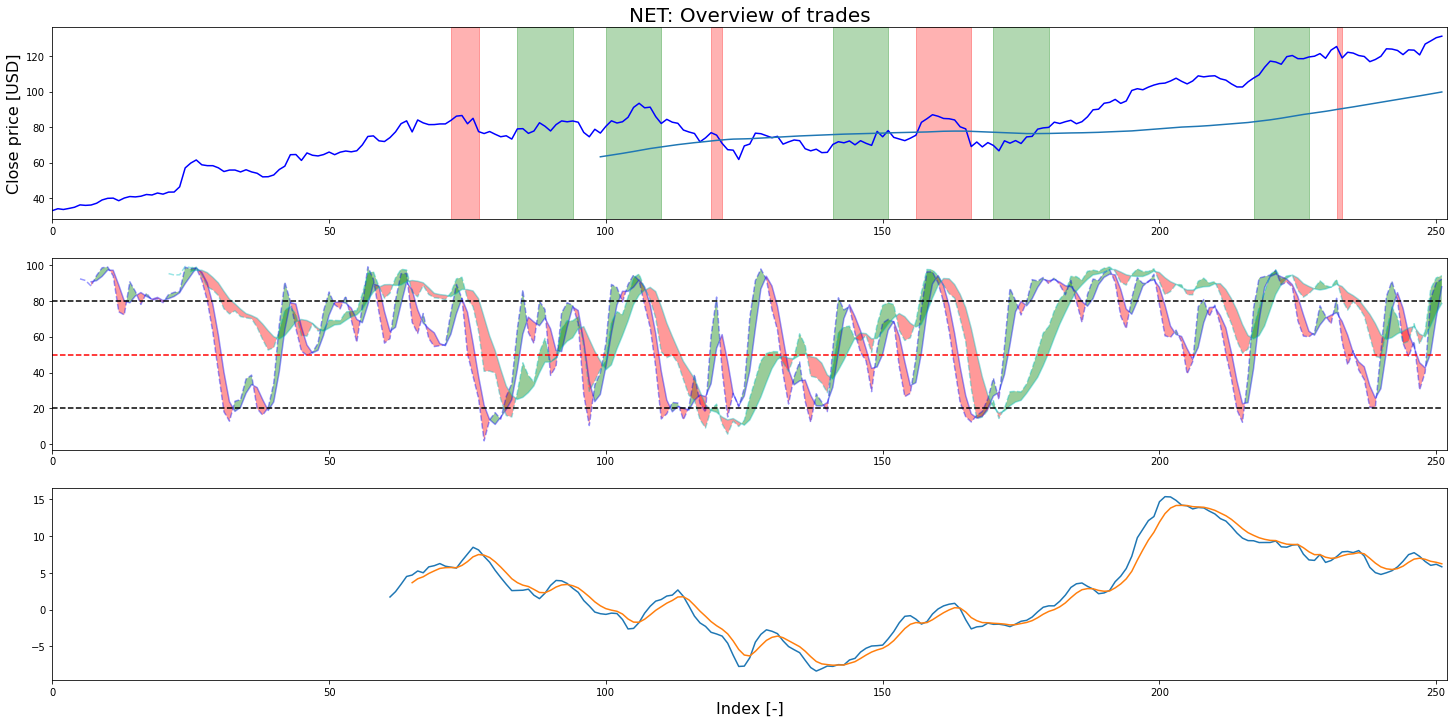

In [34]:
fig, ax = plt.subplots(nrows=3, figsize=(25,12))

# plot closed prices and highlighted trades
ax[0].plot(stock.data["Close"], color="b")
ax[0].plot(ind.sma(stock.data, 100)["SMA"])
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlim([0, stock.data.shape[0]])

# Plot double stochastic oscillator, 21 and 5
st_fast = ind.stoch(stock.data, period=21, sk=2, sd=5)
st_slow = ind.stoch(stock.data, period=5, sk=2, sd=3)
ax[1].plot(st_slow["k"], "b--", alpha=0.4)
ax[1].plot(st_slow["d"], "b", alpha=0.4)
ax[1].plot(st_fast["k"], "c--", alpha=0.4)
ax[1].plot(st_fast["d"], "c", alpha=0.4)
ax[1].fill_between(np.arange(stock.data.shape[0]), st_slow["k"], st_slow["d"], where=(st_slow["k"] >= st_slow["d"]), interpolate=True, facecolor="green", alpha=0.4)
ax[1].fill_between(np.arange(stock.data.shape[0]), st_slow["k"], st_slow["d"], where=(st_slow["k"] < st_slow["d"]), interpolate=True, facecolor="red", alpha=0.4)
ax[1].fill_between(np.arange(stock.data.shape[0]), st_fast["k"], st_fast["d"], where=(st_fast["k"] >= st_fast["d"]), interpolate=True, facecolor="green", alpha=0.4)
ax[1].fill_between(np.arange(stock.data.shape[0]), st_fast["k"], st_fast["d"], where=(st_fast["k"] < st_fast["d"]), interpolate=True, facecolor="red", alpha=0.4)
# plot y line
ax[1].plot(np.arange(stock.data.shape[0]), 80*np.ones(stock.data.shape[0]), "k--")
ax[1].plot(np.arange(stock.data.shape[0]), 50*np.ones(stock.data.shape[0]), "r--")
ax[1].plot(np.arange(stock.data.shape[0]), 20*np.ones(stock.data.shape[0]), "k--")
ax[1].set_xlim([0, stock.data.shape[0]])

# plot VFI
ax[2].plot(vfi["vfi"])
ax[2].plot(vfi["vfi_smooth"])
ax[2].set_xlim([0, stock.data.shape[0]])
ax[2].set_xlabel("Index [-]", fontsize=16)